<a href="https://colab.research.google.com/github/Tanainan/Covid-19Thailand/blob/main/Predicting_Google_mobility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U tensorflow-addons
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout, Activation
from keras.layers import GRU
from keras.layers import SimpleRNN
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow_addons.layers import InstanceNormalization, GroupNormalization
from keras.layers import LayerNormalization
from keras.layers import Flatten
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import pandas as pd
import numpy as np
from statistics import stdev
from statistics import mean
from matplotlib import pyplot
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)
from matplotlib import pyplot as plt
import datetime as dt
import matplotlib.ticker as ticker
import plotly.graph_objects as go
from statsmodels.graphics.factorplots import interaction_plot
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', None)
import itertools
!pip install -U scikit-learn
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.utils import to_categorical


     |████████████████████████████████| 1.1 MB 27.6 MB/s 


/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



     |████████████████████████████████| 23.2 MB 1.5 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
data = read_csv("https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/d98db2da901d5707dc3225ee163903005e7645f3/data/OxCGRT_latest.csv")

data = pd.DataFrame(data)

# select Thailand only
data = data.loc[data['CountryName'] == "Thailand"]

# select columns
data = data[["Date", "C1_School closing",
            "C2_Workplace closing",
            "C3_Cancel public events", "C4_Restrictions on gatherings",
            "C5_Close public transport", "C6_Stay at home requirements",
            "C7_Restrictions on internal movement", "C8_International travel controls",
            "H1_Public information campaigns", "ConfirmedCases", "ConfirmedDeaths"]]

# change column names
data = data.rename(columns = {"C1_School closing":"C1_School.closing",
            "C2_Workplace closing":"C2_Workplace.closing",
            "C3_Cancel public events":"C3_Cancel.public.events",
            "C4_Restrictions on gatherings":"C4_Restrictions.on.gatherings",
            "C5_Close public transport":"C5_Close.public.transport",
            "C6_Stay at home requirements":"C6_Stay.at.home.requirements",
            "C7_Restrictions on internal movement":"C7_Restrictions.on.internal.movement",
            "C8_International travel controls":"C8_International.travel.controls",
            "H1_Public information campaigns":"H1_Public.information.campaigns"})

# change date format
data.Date =  pd.to_datetime(data["Date"], format='%Y%m%d')

# reset index
data = data.reset_index(drop = True)

# replace NaN with 0 for ConfirmedCases and ConfirmedDeaths
data[["ConfirmedCases", "ConfirmedDeaths"]] = data[["ConfirmedCases", "ConfirmedDeaths"]].replace(np.nan, 0)

# remove NaN rows (bottom part)
data = data.dropna()

# add daily cases columns
data[["Cases_daily"]] = data['ConfirmedCases'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
data[["Deaths_daily"]] = data['ConfirmedDeaths'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])

# replace NaN with 0 for ConfirmedCases and Deaths_daily
data[["Cases_daily", "Deaths_daily"]] = data[["Cases_daily", "Deaths_daily"]].replace(np.nan, 0)


# start from 15/2/2020
data = data[data.loc[data['Date'] == "2020-02-15"].index[0]:]

# reset index
data = data.reset_index(drop = True)

# one-hot encoding
a = pd.DataFrame(to_categorical(data[["C1_School.closing"]]))
b = pd.DataFrame(to_categorical(data[["C2_Workplace.closing"]]))
c = pd.DataFrame(to_categorical(data[["C3_Cancel.public.events"]]))
d = pd.DataFrame(to_categorical(data[["C4_Restrictions.on.gatherings"]]))
e = pd.DataFrame(to_categorical(data[["C5_Close.public.transport"]]))
f = pd.DataFrame(to_categorical(data[["C6_Stay.at.home.requirements"]]))
g = pd.DataFrame(to_categorical(data[["C7_Restrictions.on.internal.movement"]]))
h = pd.DataFrame(to_categorical(data[["C8_International.travel.controls"]]))
j = pd.DataFrame(to_categorical(data[["H1_Public.information.campaigns"]]))






/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.



In [3]:
mob = read_csv("https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv")

mob = pd.DataFrame(mob)

# select only Thailand
mob = mob.loc[mob['country_region'] == "Thailand"]

# select columns
mob = mob[["date",
              "retail_and_recreation_percent_change_from_baseline",
              "grocery_and_pharmacy_percent_change_from_baseline",
              "parks_percent_change_from_baseline",
              "transit_stations_percent_change_from_baseline",
              "workplaces_percent_change_from_baseline",
              "residential_percent_change_from_baseline"]]

# change date format
mob.date =  pd.to_datetime(mob["date"])

# change column name
mob = mob.rename(columns = {'date':'Date',
                            "retail_and_recreation_percent_change_from_baseline":'retail',
                            "grocery_and_pharmacy_percent_change_from_baseline": "grocery",
                            "parks_percent_change_from_baseline":'parks',
                            "transit_stations_percent_change_from_baseline":"transit",
                            "workplaces_percent_change_from_baseline":"workplace",
                            "residential_percent_change_from_baseline":"resident"})

# reset index
mob = mob.reset_index(drop = True)

# start from 15/2/2020
mob = mob[mob.loc[mob['Date'] == "2020-02-15"].index[0]:]

# omit Date column
mob0 = mob.drop(["Date"], axis = 1)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.



In [24]:
# whichever has fewer data
length = min(len(data), len(mob))

# Cases daily
data_mob = pd.concat([#data.Cases_daily[:length], 
                    # data.Deaths_daily[:length],
                    data.Date[:length], 
                    # a[:length],
                    # b[:length],
                    # c[:length],
                    # d[:length],
                    # e[:length],
                    # f[:length],
                    # g[:length],
                    # h[:length],
                    # j[:length],
                    mob0[:length]], axis = 1)

# start on 1/8/2021
data_mob0 = data_mob[data_mob.loc[data_mob['Date'] == "2021-06-15"].index[0]:].reset_index(drop = True)

# plt.rcParams["figure.figsize"] = (20,10)
# plt.plot(data_mob["Date"], data_mob['retail'])
# plt.plot(data_mob["Date"], data_mob['grocery'])
# plt.plot(data_mob["Date"], data_mob['parks'])
# plt.plot(data_mob["Date"], data_mob['transit'])
# plt.plot(data_mob["Date"], data_mob['workplace'])
# plt.plot(data_mob["Date"], data_mob['resident'])
# plt.tick_params('x',labelrotation=90)

# drop date column
data_mob = data_mob0.drop(["Date"], axis = 1)


In [6]:
lag = 14
prediction = 1
window = 3 # for moving average
index = 30

# moving average
# data_mob['Cases_daily'] = data_mob.Cases_daily.rolling(window).mean()
# data_mob['Deaths_daily'] = data_mob.Deaths_daily.rolling(window).mean()

# data_mob['retail'] = data_mob.retail.rolling(window).mean()
# data_mob['grocery'] = data_mob.grocery.rolling(window).mean()
# data_mob['parks'] = data_mob.parks.rolling(window).mean()
# data_mob['transit'] = data_mob.transit.rolling(window).mean()
# data_mob['workplace'] = data_mob.workplace.rolling(window).mean()
# data_mob['resident'] = data_mob.resident.rolling(window).mean()

# remove NaN
data_mob.dropna(subset = [#"Cases_daily", "Deaths_daily",
                          "retail","grocery","parks","transit","workplace","resident"], inplace=True)

data_mob = data_mob.reset_index(drop = True)

nrow_total = data_mob.shape[0]-lag
input_list = [np.expand_dims(data_mob[i:lag+i], axis=0) for i in range(nrow_total)] 
X_mob = np.concatenate(input_list, axis=0)

y_mob = list()
for col in data_mob[["retail","grocery","parks","transit","workplace","resident"]]:
  input_list = [np.expand_dims(data_mob[lag+i:lag+i+1][col], axis=0) for i in range(nrow_total)] 
  y = np.concatenate(input_list, axis=0)
  y_mob.append(y)
y_mob = np.array(y_mob)
y_mob = y_mob.swapaxes(0,1).swapaxes(1,2)

# split into training and test sets
X_mob_tr = X_mob[0:index+1, :, :]
X_mob_ts = X_mob[index+1:data_mob.shape[0], :, :]



# Retail

In [9]:
y_mob_tr = y_mob[0:index+1, :, 0]
y_mob_ts = y_mob[index+1:data_mob.shape[0], :, 0] # retail

## Tuning

In [10]:
# CNN Tuning

def evaluate_cnn(trainX, trainy, filter, kernel_size, pool):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(Conv1D(filters = filter, kernel_size=kernel_size, activation='relu',input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size= pool))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# run an experiment
def run_experiment(filters, kernel_size, pool, trainX, trainy):
    # test each parameter
    all_scores = list()
    for filter in filters:
      for kernel in kernel_size:
        for pooling in pool:
          score = evaluate_cnn(trainX, trainy, filter, kernel_size, pool)
          print('filter = %d, kernel size = %d, pooling size = %d: %.3f' % (filter, kernel, pooling, score))
          all_scores.append(score)
    return all_scores
    


filter = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] 

kernel = [3, 5, 7]
pool = [2]
cnn_mob = list()

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool,X_mob_tr, y_mob_tr)
    cnn_mob.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_mob_tr, y_mob_tr)
    cnn_mob.append(score)

cnn_mob = pd.DataFrame(cnn_mob).T
cnn_mob.columns = ['k3p2', 'k5p2','k7p2', 'k3p3', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 89.044
filter = 4, kernel size = 3, pooling size = 2: 14.908
filter = 8, kernel size = 3, pooling size = 2: 15.884
filter = 16, kernel size = 3, pooling size = 2: 13.780
filter = 32, kernel size = 3, pooling size = 2: 9.643
filter = 64, kernel size = 3, pooling size = 2: 12.786
filter = 128, kernel size = 3, pooling size = 2: 14.887
filter = 256, kernel size = 3, pooling size = 2: 9.442
filter = 512, kernel size = 3, pooling size = 2: 7.368
filter = 1024, kernel size = 3, pooling size = 2: 12.636
filter = 2, kernel size = 5, pooling size = 2: 89.075
filter = 4, kernel size = 5, pooling size = 2: 14.134
filter = 8, kernel size = 5, pooling size = 2: 16.914
filter = 16, kernel size = 5, pooling size = 2: 10.939
filter = 32, kernel size = 5, pooling size = 2: 17.808
filter = 64, kernel size = 5, pooling size = 2: 5.217
filter = 128, kernel size = 5, pooling size = 2: 6.674
filter = 256, kernel size = 5, pooling size = 2: 8.274
filter = 512, k

In [11]:
# LSTM
def evaluate_lstm(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(LSTM(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


units = [2, 4,8,16,32,64,128,256,512, 1024]

lstm_mob = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_mob_tr, y_mob_tr, i)
  lstm_mob.append(score)

In [12]:
# GRU
def evaluate_gru(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(GRU(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

gru_mob = list()

for i in units:
  score = list()
  score = evaluate_gru(X_mob_tr, y_mob_tr, i)
  gru_mob.append(score)

In [13]:
# RNN
def evaluate_rnn(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(SimpleRNN(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

rnn_mob = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_mob_tr, y_mob_tr, i)
  rnn_mob.append(score)

In [14]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes', '4 Nodes', '8 Nodes', '16 Nodes', '32 Nodes',
                                                   "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes', '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_mob[0],3), 
                                     round(gru_mob[0],3),
                                     round(rnn_mob[0],3), 
                                     round(cnn_mob.iloc[0,0],3),
                                     round(cnn_mob.iloc[0,1],3),
                                     round(cnn_mob.iloc[0,2],3),
                                     round(cnn_mob.iloc[0,3],3),
                                     round(cnn_mob.iloc[0,4],3),
                                     round(cnn_mob.iloc[0,5],3)],
                                     [round(lstm_mob[1],3), 
                                     round(gru_mob[1],3),
                                     round(rnn_mob[1],3), 
                                     round(cnn_mob.iloc[1,0],3),
                                     round(cnn_mob.iloc[1,1],3),
                                     round(cnn_mob.iloc[1,2],3),
                                     round(cnn_mob.iloc[1,3],3),
                                     round(cnn_mob.iloc[1,4],3),
                                     round(cnn_mob.iloc[1,5],3)],
                                     [round(lstm_mob[2],3), 
                                     round(gru_mob[2],3),
                                     round(rnn_mob[2],3), 
                                     round(cnn_mob.iloc[2,0],3),
                                     round(cnn_mob.iloc[2,1],3),
                                     round(cnn_mob.iloc[2,2],3),
                                     round(cnn_mob.iloc[2,3],3),
                                     round(cnn_mob.iloc[2,4],3),
                                     round(cnn_mob.iloc[2,5],3)],
                                     [round(lstm_mob[3],3), 
                                     round(gru_mob[3],3),
                                     round(rnn_mob[3],3), 
                                     round(cnn_mob.iloc[3,0],3),
                                     round(cnn_mob.iloc[3,1],3),
                                     round(cnn_mob.iloc[3,2],3),
                                     round(cnn_mob.iloc[3,3],3),
                                     round(cnn_mob.iloc[3,4],3),
                                     round(cnn_mob.iloc[3,5],3)],
                                     [round(lstm_mob[4],3), 
                                     round(gru_mob[4],3),
                                     round(rnn_mob[4],3), 
                                     round(cnn_mob.iloc[4,0],3),
                                     round(cnn_mob.iloc[4,1],3),
                                     round(cnn_mob.iloc[4,2],3),
                                     round(cnn_mob.iloc[4,3],3),
                                     round(cnn_mob.iloc[4,4],3),
                                     round(cnn_mob.iloc[4,5],3)],
                                     [round(lstm_mob[5],3), 
                                     round(gru_mob[5],3),
                                     round(rnn_mob[5],3), 
                                     round(cnn_mob.iloc[5,0],3),
                                     round(cnn_mob.iloc[5,1],3),
                                     round(cnn_mob.iloc[5,2],3),
                                     round(cnn_mob.iloc[5,3],3),
                                     round(cnn_mob.iloc[5,4],3),
                                     round(cnn_mob.iloc[5,5],3)],
                                     [round(lstm_mob[6],3), 
                                     round(gru_mob[6],3),
                                     round(rnn_mob[6],3), 
                                     round(cnn_mob.iloc[6,0],3),
                                     round(cnn_mob.iloc[6,1],3),
                                     round(cnn_mob.iloc[6,2],3),
                                     round(cnn_mob.iloc[6,3],3),
                                     round(cnn_mob.iloc[6,4],3),
                                     round(cnn_mob.iloc[6,5],3)],
                                     [round(lstm_mob[7],3), 
                                     round(gru_mob[7],3),
                                     round(rnn_mob[7],3), 
                                     round(cnn_mob.iloc[7,0],3),
                                     round(cnn_mob.iloc[7,1],3),
                                     round(cnn_mob.iloc[7,2],3),
                                     round(cnn_mob.iloc[7,3],3),
                                     round(cnn_mob.iloc[7,4],3),
                                     round(cnn_mob.iloc[7,5],3)],
                                     [round(lstm_mob[8],3), 
                                     round(gru_mob[8],3),
                                     round(rnn_mob[8],3), 
                                     round(cnn_mob.iloc[8,0],3),
                                     round(cnn_mob.iloc[8,1],3),
                                     round(cnn_mob.iloc[8,2],3),
                                     round(cnn_mob.iloc[8,3],3),
                                     round(cnn_mob.iloc[8,4],3),
                                     round(cnn_mob.iloc[8,5],3)],
                                     [round(lstm_mob[9],3), 
                                     round(gru_mob[9],3),
                                     round(rnn_mob[9],3), 
                                     round(cnn_mob.iloc[9,0],3),
                                     round(cnn_mob.iloc[9,1],3),
                                     round(cnn_mob.iloc[9,2],3),
                                     round(cnn_mob.iloc[9,3],3),
                                     round(cnn_mob.iloc[9,4],3),
                                     round(cnn_mob.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right', 'right', 'right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Google Mobility",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

## Prediction

In [15]:
seed(1)
tensorflow.random.set_seed(1)

model_mob = Sequential()
model_mob.add(GRU(256, activation='relu', input_shape=(X_mob_tr.shape[1], X_mob_tr.shape[2])))
# model_mob.add(Dense(2, activation = "relu"))
model_mob.add(Dense(1, activation = "linear"))
model_mob.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_mob.fit(X_mob_tr, y_mob_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

scores_mob1 = model_mob.evaluate(X_mob_tr, y_mob_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_mob1[1])

scores_mob = model_mob.evaluate(X_mob_ts, y_mob_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_mob[1])


# make a prediction
# training set
y_mob_tr = pd.DataFrame(model_mob.predict(X_mob_tr))

# test set
y_mob_ts = pd.DataFrame(model_mob.predict(X_mob_ts))

# combine training and test predictions
y_mob_total_retail = pd.concat([y_mob_tr, y_mob_ts], ignore_index=True)



MAPE: training =  5.074786186218262
MAPE: test =  154854880.0


## Plot

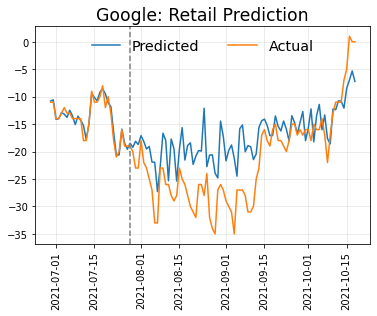

In [26]:

retail = pd.concat([y_mob_total_retail,
                data_mob0.retail.iloc[lag:].reset_index(drop = True),
                data_mob0.Date.iloc[lag:].reset_index(drop = True)], axis=1)

retail.columns = ['retail', "Actual", 'Date']

tick_spacing = 5
date_test = data_mob0['Date'][0+index+lag-1]

plt.plot(retail['Date'],retail['retail'], label = "Predicted")
plt.plot(retail['Date'],retail['Actual'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Google: Retail Prediction", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)


# Grocery

In [27]:
y_mob_tr = y_mob[0:index+1, :, 1]
y_mob_ts = y_mob[index+1:data_mob.shape[0], :, 1] # grocery

## Tuning

In [28]:
# CNN Tuning

def evaluate_cnn(trainX, trainy, filter, kernel_size, pool):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(Conv1D(filters = filter, kernel_size=kernel_size, activation='relu',input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size= pool))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# run an experiment
def run_experiment(filters, kernel_size, pool, trainX, trainy):
    # test each parameter
    all_scores = list()
    for filter in filters:
      for kernel in kernel_size:
        for pooling in pool:
          score = evaluate_cnn(trainX, trainy, filter, kernel_size, pool)
          print('filter = %d, kernel size = %d, pooling size = %d: %.3f' % (filter, kernel, pooling, score))
          all_scores.append(score)
    return all_scores
    


filter = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] 

kernel = [3, 5, 7]
pool = [2]
cnn_mob = list()

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool,X_mob_tr, y_mob_tr)
    cnn_mob.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_mob_tr, y_mob_tr)
    cnn_mob.append(score)

cnn_mob = pd.DataFrame(cnn_mob).T
cnn_mob.columns = ['k3p2', 'k5p2','k7p2', 'k3p3', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 88.861
filter = 4, kernel size = 3, pooling size = 2: 30.324
filter = 8, kernel size = 3, pooling size = 2: 16.301
filter = 16, kernel size = 3, pooling size = 2: 21.979
filter = 32, kernel size = 3, pooling size = 2: 14.542
filter = 64, kernel size = 3, pooling size = 2: 14.125
filter = 128, kernel size = 3, pooling size = 2: 10.579
filter = 256, kernel size = 3, pooling size = 2: 44.115
filter = 512, kernel size = 3, pooling size = 2: 17.148
filter = 1024, kernel size = 3, pooling size = 2: 58.599
filter = 2, kernel size = 5, pooling size = 2: 44.328
filter = 4, kernel size = 5, pooling size = 2: 25.437
filter = 8, kernel size = 5, pooling size = 2: 17.023
filter = 16, kernel size = 5, pooling size = 2: 21.131
filter = 32, kernel size = 5, pooling size = 2: 10.346
filter = 64, kernel size = 5, pooling size = 2: 6.982
filter = 128, kernel size = 5, pooling size = 2: 8.658
filter = 256, kernel size = 5, pooling size = 2: 7.987
filter = 512

In [29]:
# LSTM
def evaluate_lstm(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(LSTM(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


units = [2, 4,8,16,32,64,128,256,512, 1024]

lstm_mob = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_mob_tr, y_mob_tr, i)
  lstm_mob.append(score)

In [30]:
# GRU
def evaluate_gru(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(GRU(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

gru_mob = list()

for i in units:
  score = list()
  score = evaluate_gru(X_mob_tr, y_mob_tr, i)
  gru_mob.append(score)

In [31]:
# RNN
def evaluate_rnn(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(SimpleRNN(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

rnn_mob = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_mob_tr, y_mob_tr, i)
  rnn_mob.append(score)

In [32]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes', '4 Nodes', '8 Nodes', '16 Nodes', '32 Nodes',
                                                   "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes', '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_mob[0],3), 
                                     round(gru_mob[0],3),
                                     round(rnn_mob[0],3), 
                                     round(cnn_mob.iloc[0,0],3),
                                     round(cnn_mob.iloc[0,1],3),
                                     round(cnn_mob.iloc[0,2],3),
                                     round(cnn_mob.iloc[0,3],3),
                                     round(cnn_mob.iloc[0,4],3),
                                     round(cnn_mob.iloc[0,5],3)],
                                     [round(lstm_mob[1],3), 
                                     round(gru_mob[1],3),
                                     round(rnn_mob[1],3), 
                                     round(cnn_mob.iloc[1,0],3),
                                     round(cnn_mob.iloc[1,1],3),
                                     round(cnn_mob.iloc[1,2],3),
                                     round(cnn_mob.iloc[1,3],3),
                                     round(cnn_mob.iloc[1,4],3),
                                     round(cnn_mob.iloc[1,5],3)],
                                     [round(lstm_mob[2],3), 
                                     round(gru_mob[2],3),
                                     round(rnn_mob[2],3), 
                                     round(cnn_mob.iloc[2,0],3),
                                     round(cnn_mob.iloc[2,1],3),
                                     round(cnn_mob.iloc[2,2],3),
                                     round(cnn_mob.iloc[2,3],3),
                                     round(cnn_mob.iloc[2,4],3),
                                     round(cnn_mob.iloc[2,5],3)],
                                     [round(lstm_mob[3],3), 
                                     round(gru_mob[3],3),
                                     round(rnn_mob[3],3), 
                                     round(cnn_mob.iloc[3,0],3),
                                     round(cnn_mob.iloc[3,1],3),
                                     round(cnn_mob.iloc[3,2],3),
                                     round(cnn_mob.iloc[3,3],3),
                                     round(cnn_mob.iloc[3,4],3),
                                     round(cnn_mob.iloc[3,5],3)],
                                     [round(lstm_mob[4],3), 
                                     round(gru_mob[4],3),
                                     round(rnn_mob[4],3), 
                                     round(cnn_mob.iloc[4,0],3),
                                     round(cnn_mob.iloc[4,1],3),
                                     round(cnn_mob.iloc[4,2],3),
                                     round(cnn_mob.iloc[4,3],3),
                                     round(cnn_mob.iloc[4,4],3),
                                     round(cnn_mob.iloc[4,5],3)],
                                     [round(lstm_mob[5],3), 
                                     round(gru_mob[5],3),
                                     round(rnn_mob[5],3), 
                                     round(cnn_mob.iloc[5,0],3),
                                     round(cnn_mob.iloc[5,1],3),
                                     round(cnn_mob.iloc[5,2],3),
                                     round(cnn_mob.iloc[5,3],3),
                                     round(cnn_mob.iloc[5,4],3),
                                     round(cnn_mob.iloc[5,5],3)],
                                     [round(lstm_mob[6],3), 
                                     round(gru_mob[6],3),
                                     round(rnn_mob[6],3), 
                                     round(cnn_mob.iloc[6,0],3),
                                     round(cnn_mob.iloc[6,1],3),
                                     round(cnn_mob.iloc[6,2],3),
                                     round(cnn_mob.iloc[6,3],3),
                                     round(cnn_mob.iloc[6,4],3),
                                     round(cnn_mob.iloc[6,5],3)],
                                     [round(lstm_mob[7],3), 
                                     round(gru_mob[7],3),
                                     round(rnn_mob[7],3), 
                                     round(cnn_mob.iloc[7,0],3),
                                     round(cnn_mob.iloc[7,1],3),
                                     round(cnn_mob.iloc[7,2],3),
                                     round(cnn_mob.iloc[7,3],3),
                                     round(cnn_mob.iloc[7,4],3),
                                     round(cnn_mob.iloc[7,5],3)],
                                     [round(lstm_mob[8],3), 
                                     round(gru_mob[8],3),
                                     round(rnn_mob[8],3), 
                                     round(cnn_mob.iloc[8,0],3),
                                     round(cnn_mob.iloc[8,1],3),
                                     round(cnn_mob.iloc[8,2],3),
                                     round(cnn_mob.iloc[8,3],3),
                                     round(cnn_mob.iloc[8,4],3),
                                     round(cnn_mob.iloc[8,5],3)],
                                     [round(lstm_mob[9],3), 
                                     round(gru_mob[9],3),
                                     round(rnn_mob[9],3), 
                                     round(cnn_mob.iloc[9,0],3),
                                     round(cnn_mob.iloc[9,1],3),
                                     round(cnn_mob.iloc[9,2],3),
                                     round(cnn_mob.iloc[9,3],3),
                                     round(cnn_mob.iloc[9,4],3),
                                     round(cnn_mob.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right', 'right', 'right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Google Mobility",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

## Prediction

In [33]:
seed(1)
tensorflow.random.set_seed(1)

model_mob = Sequential()
model_mob.add(GRU(128, activation='relu', input_shape=(X_mob_tr.shape[1], X_mob_tr.shape[2])))
# model_mob.add(Dense(2, activation = "relu"))
model_mob.add(Dense(1, activation = "linear"))
model_mob.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_mob.fit(X_mob_tr, y_mob_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

scores_mob1 = model_mob.evaluate(X_mob_tr, y_mob_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_mob1[1])

scores_mob = model_mob.evaluate(X_mob_ts, y_mob_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_mob[1])


# make a prediction
# training set
y_mob_tr = pd.DataFrame(model_mob.predict(X_mob_tr))

# test set
y_mob_ts = pd.DataFrame(model_mob.predict(X_mob_ts))

# combine training and test predictions
y_mob_total_grocery = pd.concat([y_mob_tr, y_mob_ts], ignore_index=True)



MAPE: training =  6.853490352630615
MAPE: test =  147238992.0


## Plot

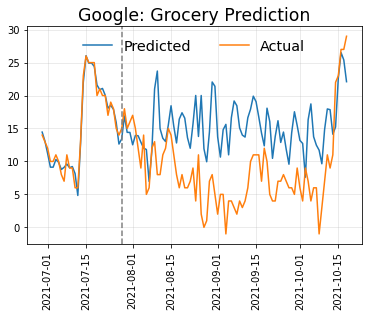

In [34]:

grocery = pd.concat([y_mob_total_grocery,
                data_mob0.grocery.iloc[lag:].reset_index(drop = True),
                data_mob0.Date.iloc[lag:].reset_index(drop = True)], axis=1)

grocery.columns = ['grocery', "Actual", 'Date']


plt.plot(grocery['Date'],grocery['grocery'], label = "Predicted")
plt.plot(grocery['Date'],grocery['Actual'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Google: Grocery Prediction", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)


# Parks

In [35]:
y_mob_tr = y_mob[0:index+1, :, 2]
y_mob_ts = y_mob[index+1:data_mob.shape[0], :, 2] # parks

## Tuning

In [36]:
# CNN Tuning

def evaluate_cnn(trainX, trainy, filter, kernel_size, pool):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(Conv1D(filters = filter, kernel_size=kernel_size, activation='relu',input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size= pool))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# run an experiment
def run_experiment(filters, kernel_size, pool, trainX, trainy):
    # test each parameter
    all_scores = list()
    for filter in filters:
      for kernel in kernel_size:
        for pooling in pool:
          score = evaluate_cnn(trainX, trainy, filter, kernel_size, pool)
          print('filter = %d, kernel size = %d, pooling size = %d: %.3f' % (filter, kernel, pooling, score))
          all_scores.append(score)
    return all_scores
    


filter = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] 

kernel = [3, 5, 7]
pool = [2]
cnn_mob = list()

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool,X_mob_tr, y_mob_tr)
    cnn_mob.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_mob_tr, y_mob_tr)
    cnn_mob.append(score)

cnn_mob = pd.DataFrame(cnn_mob).T
cnn_mob.columns = ['k3p2', 'k5p2','k7p2', 'k3p3', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 95.889
filter = 4, kernel size = 3, pooling size = 2: 8.097
filter = 8, kernel size = 3, pooling size = 2: 6.309
filter = 16, kernel size = 3, pooling size = 2: 6.533
filter = 32, kernel size = 3, pooling size = 2: 19.098
filter = 64, kernel size = 3, pooling size = 2: 6.650
filter = 128, kernel size = 3, pooling size = 2: 6.156
filter = 256, kernel size = 3, pooling size = 2: 31.888
filter = 512, kernel size = 3, pooling size = 2: 30.070
filter = 1024, kernel size = 3, pooling size = 2: 24.267
filter = 2, kernel size = 5, pooling size = 2: 95.893
filter = 4, kernel size = 5, pooling size = 2: 7.448
filter = 8, kernel size = 5, pooling size = 2: 5.746
filter = 16, kernel size = 5, pooling size = 2: 4.984
filter = 32, kernel size = 5, pooling size = 2: 6.751
filter = 64, kernel size = 5, pooling size = 2: 18.837
filter = 128, kernel size = 5, pooling size = 2: 33.043
filter = 256, kernel size = 5, pooling size = 2: 29.079
filter = 512, kern

In [37]:
# LSTM
def evaluate_lstm(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(LSTM(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


units = [2, 4,8,16,32,64,128,256,512, 1024]

lstm_mob = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_mob_tr, y_mob_tr, i)
  lstm_mob.append(score)

In [38]:
# GRU
def evaluate_gru(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(GRU(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

gru_mob = list()

for i in units:
  score = list()
  score = evaluate_gru(X_mob_tr, y_mob_tr, i)
  gru_mob.append(score)

In [39]:
# RNN
def evaluate_rnn(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(SimpleRNN(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

rnn_mob = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_mob_tr, y_mob_tr, i)
  rnn_mob.append(score)

In [40]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes', '4 Nodes', '8 Nodes', '16 Nodes', '32 Nodes',
                                                   "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes', '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_mob[0],3), 
                                     round(gru_mob[0],3),
                                     round(rnn_mob[0],3), 
                                     round(cnn_mob.iloc[0,0],3),
                                     round(cnn_mob.iloc[0,1],3),
                                     round(cnn_mob.iloc[0,2],3),
                                     round(cnn_mob.iloc[0,3],3),
                                     round(cnn_mob.iloc[0,4],3),
                                     round(cnn_mob.iloc[0,5],3)],
                                     [round(lstm_mob[1],3), 
                                     round(gru_mob[1],3),
                                     round(rnn_mob[1],3), 
                                     round(cnn_mob.iloc[1,0],3),
                                     round(cnn_mob.iloc[1,1],3),
                                     round(cnn_mob.iloc[1,2],3),
                                     round(cnn_mob.iloc[1,3],3),
                                     round(cnn_mob.iloc[1,4],3),
                                     round(cnn_mob.iloc[1,5],3)],
                                     [round(lstm_mob[2],3), 
                                     round(gru_mob[2],3),
                                     round(rnn_mob[2],3), 
                                     round(cnn_mob.iloc[2,0],3),
                                     round(cnn_mob.iloc[2,1],3),
                                     round(cnn_mob.iloc[2,2],3),
                                     round(cnn_mob.iloc[2,3],3),
                                     round(cnn_mob.iloc[2,4],3),
                                     round(cnn_mob.iloc[2,5],3)],
                                     [round(lstm_mob[3],3), 
                                     round(gru_mob[3],3),
                                     round(rnn_mob[3],3), 
                                     round(cnn_mob.iloc[3,0],3),
                                     round(cnn_mob.iloc[3,1],3),
                                     round(cnn_mob.iloc[3,2],3),
                                     round(cnn_mob.iloc[3,3],3),
                                     round(cnn_mob.iloc[3,4],3),
                                     round(cnn_mob.iloc[3,5],3)],
                                     [round(lstm_mob[4],3), 
                                     round(gru_mob[4],3),
                                     round(rnn_mob[4],3), 
                                     round(cnn_mob.iloc[4,0],3),
                                     round(cnn_mob.iloc[4,1],3),
                                     round(cnn_mob.iloc[4,2],3),
                                     round(cnn_mob.iloc[4,3],3),
                                     round(cnn_mob.iloc[4,4],3),
                                     round(cnn_mob.iloc[4,5],3)],
                                     [round(lstm_mob[5],3), 
                                     round(gru_mob[5],3),
                                     round(rnn_mob[5],3), 
                                     round(cnn_mob.iloc[5,0],3),
                                     round(cnn_mob.iloc[5,1],3),
                                     round(cnn_mob.iloc[5,2],3),
                                     round(cnn_mob.iloc[5,3],3),
                                     round(cnn_mob.iloc[5,4],3),
                                     round(cnn_mob.iloc[5,5],3)],
                                     [round(lstm_mob[6],3), 
                                     round(gru_mob[6],3),
                                     round(rnn_mob[6],3), 
                                     round(cnn_mob.iloc[6,0],3),
                                     round(cnn_mob.iloc[6,1],3),
                                     round(cnn_mob.iloc[6,2],3),
                                     round(cnn_mob.iloc[6,3],3),
                                     round(cnn_mob.iloc[6,4],3),
                                     round(cnn_mob.iloc[6,5],3)],
                                     [round(lstm_mob[7],3), 
                                     round(gru_mob[7],3),
                                     round(rnn_mob[7],3), 
                                     round(cnn_mob.iloc[7,0],3),
                                     round(cnn_mob.iloc[7,1],3),
                                     round(cnn_mob.iloc[7,2],3),
                                     round(cnn_mob.iloc[7,3],3),
                                     round(cnn_mob.iloc[7,4],3),
                                     round(cnn_mob.iloc[7,5],3)],
                                     [round(lstm_mob[8],3), 
                                     round(gru_mob[8],3),
                                     round(rnn_mob[8],3), 
                                     round(cnn_mob.iloc[8,0],3),
                                     round(cnn_mob.iloc[8,1],3),
                                     round(cnn_mob.iloc[8,2],3),
                                     round(cnn_mob.iloc[8,3],3),
                                     round(cnn_mob.iloc[8,4],3),
                                     round(cnn_mob.iloc[8,5],3)],
                                     [round(lstm_mob[9],3), 
                                     round(gru_mob[9],3),
                                     round(rnn_mob[9],3), 
                                     round(cnn_mob.iloc[9,0],3),
                                     round(cnn_mob.iloc[9,1],3),
                                     round(cnn_mob.iloc[9,2],3),
                                     round(cnn_mob.iloc[9,3],3),
                                     round(cnn_mob.iloc[9,4],3),
                                     round(cnn_mob.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right', 'right', 'right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Google Mobility",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

## Prediction

In [43]:
seed(1)
tensorflow.random.set_seed(1)

model_mob = Sequential()
model_mob.add(Conv1D(32, kernel_size = 7, activation='relu', input_shape=(X_mob_tr.shape[1], X_mob_tr.shape[2])))
model_mob.add(MaxPooling1D(2))
model_mob.add(Flatten())
# model_mob.add(Dense(2, activation = "relu"))
model_mob.add(Dense(1, activation = "linear"))
model_mob.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_mob.fit(X_mob_tr, y_mob_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

scores_mob1 = model_mob.evaluate(X_mob_tr, y_mob_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_mob1[1])

scores_mob = model_mob.evaluate(X_mob_ts, y_mob_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_mob[1])


# make a prediction
# training set
y_mob_tr = pd.DataFrame(model_mob.predict(X_mob_tr))

# test set
y_mob_ts = pd.DataFrame(model_mob.predict(X_mob_ts))

# combine training and test predictions
y_mob_total_parks = pd.concat([y_mob_tr, y_mob_ts], ignore_index=True)



MAPE: training =  1.857905387878418
MAPE: test =  6.978901386260986


## Plot

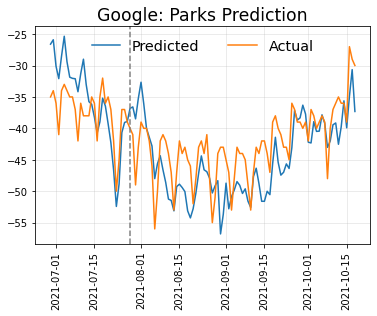

In [44]:

parks = pd.concat([y_mob_total_parks,
                data_mob0.parks.iloc[lag:].reset_index(drop = True),
                data_mob0.Date.iloc[lag:].reset_index(drop = True)], axis=1)

parks.columns = ['parks', "Actual", 'Date']

tick_spacing = 5
date_test = data_mob0['Date'][0+index+lag-1]

plt.plot(parks['Date'],parks['parks'], label = "Predicted")
plt.plot(parks['Date'],parks['Actual'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Google: Parks Prediction", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)


# Transit

In [45]:
y_mob_tr = y_mob[0:index+1, :, 3]
y_mob_ts = y_mob[index+1:data_mob.shape[0], :, 3] # transit

## Tuning

In [46]:
# CNN Tuning

def evaluate_cnn(trainX, trainy, filter, kernel_size, pool):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(Conv1D(filters = filter, kernel_size=kernel_size, activation='relu',input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size= pool))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# run an experiment
def run_experiment(filters, kernel_size, pool, trainX, trainy):
    # test each parameter
    all_scores = list()
    for filter in filters:
      for kernel in kernel_size:
        for pooling in pool:
          score = evaluate_cnn(trainX, trainy, filter, kernel_size, pool)
          print('filter = %d, kernel size = %d, pooling size = %d: %.3f' % (filter, kernel, pooling, score))
          all_scores.append(score)
    return all_scores
    


filter = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] 

kernel = [3, 5, 7]
pool = [2]
cnn_mob = list()

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool,X_mob_tr, y_mob_tr)
    cnn_mob.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_mob_tr, y_mob_tr)
    cnn_mob.append(score)

cnn_mob = pd.DataFrame(cnn_mob).T
cnn_mob.columns = ['k3p2', 'k5p2','k7p2', 'k3p3', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 97.020
filter = 4, kernel size = 3, pooling size = 2: 3.483
filter = 8, kernel size = 3, pooling size = 2: 2.661
filter = 16, kernel size = 3, pooling size = 2: 2.864
filter = 32, kernel size = 3, pooling size = 2: 7.535
filter = 64, kernel size = 3, pooling size = 2: 7.830
filter = 128, kernel size = 3, pooling size = 2: 4.333
filter = 256, kernel size = 3, pooling size = 2: 9.692
filter = 512, kernel size = 3, pooling size = 2: 15.194
filter = 1024, kernel size = 3, pooling size = 2: 3.648
filter = 2, kernel size = 5, pooling size = 2: 97.022
filter = 4, kernel size = 5, pooling size = 2: 2.625
filter = 8, kernel size = 5, pooling size = 2: 2.189
filter = 16, kernel size = 5, pooling size = 2: 2.508
filter = 32, kernel size = 5, pooling size = 2: 10.158
filter = 64, kernel size = 5, pooling size = 2: 2.112
filter = 128, kernel size = 5, pooling size = 2: 2.987
filter = 256, kernel size = 5, pooling size = 2: 4.759
filter = 512, kernel si

In [47]:
# LSTM
def evaluate_lstm(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(LSTM(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


units = [2, 4,8,16,32,64,128,256,512, 1024]

lstm_mob = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_mob_tr, y_mob_tr, i)
  lstm_mob.append(score)

In [48]:
# GRU
def evaluate_gru(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(GRU(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

gru_mob = list()

for i in units:
  score = list()
  score = evaluate_gru(X_mob_tr, y_mob_tr, i)
  gru_mob.append(score)

In [49]:
# RNN
def evaluate_rnn(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(SimpleRNN(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

rnn_mob = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_mob_tr, y_mob_tr, i)
  rnn_mob.append(score)

In [50]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes', '4 Nodes', '8 Nodes', '16 Nodes', '32 Nodes',
                                                   "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes', '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_mob[0],3), 
                                     round(gru_mob[0],3),
                                     round(rnn_mob[0],3), 
                                     round(cnn_mob.iloc[0,0],3),
                                     round(cnn_mob.iloc[0,1],3),
                                     round(cnn_mob.iloc[0,2],3),
                                     round(cnn_mob.iloc[0,3],3),
                                     round(cnn_mob.iloc[0,4],3),
                                     round(cnn_mob.iloc[0,5],3)],
                                     [round(lstm_mob[1],3), 
                                     round(gru_mob[1],3),
                                     round(rnn_mob[1],3), 
                                     round(cnn_mob.iloc[1,0],3),
                                     round(cnn_mob.iloc[1,1],3),
                                     round(cnn_mob.iloc[1,2],3),
                                     round(cnn_mob.iloc[1,3],3),
                                     round(cnn_mob.iloc[1,4],3),
                                     round(cnn_mob.iloc[1,5],3)],
                                     [round(lstm_mob[2],3), 
                                     round(gru_mob[2],3),
                                     round(rnn_mob[2],3), 
                                     round(cnn_mob.iloc[2,0],3),
                                     round(cnn_mob.iloc[2,1],3),
                                     round(cnn_mob.iloc[2,2],3),
                                     round(cnn_mob.iloc[2,3],3),
                                     round(cnn_mob.iloc[2,4],3),
                                     round(cnn_mob.iloc[2,5],3)],
                                     [round(lstm_mob[3],3), 
                                     round(gru_mob[3],3),
                                     round(rnn_mob[3],3), 
                                     round(cnn_mob.iloc[3,0],3),
                                     round(cnn_mob.iloc[3,1],3),
                                     round(cnn_mob.iloc[3,2],3),
                                     round(cnn_mob.iloc[3,3],3),
                                     round(cnn_mob.iloc[3,4],3),
                                     round(cnn_mob.iloc[3,5],3)],
                                     [round(lstm_mob[4],3), 
                                     round(gru_mob[4],3),
                                     round(rnn_mob[4],3), 
                                     round(cnn_mob.iloc[4,0],3),
                                     round(cnn_mob.iloc[4,1],3),
                                     round(cnn_mob.iloc[4,2],3),
                                     round(cnn_mob.iloc[4,3],3),
                                     round(cnn_mob.iloc[4,4],3),
                                     round(cnn_mob.iloc[4,5],3)],
                                     [round(lstm_mob[5],3), 
                                     round(gru_mob[5],3),
                                     round(rnn_mob[5],3), 
                                     round(cnn_mob.iloc[5,0],3),
                                     round(cnn_mob.iloc[5,1],3),
                                     round(cnn_mob.iloc[5,2],3),
                                     round(cnn_mob.iloc[5,3],3),
                                     round(cnn_mob.iloc[5,4],3),
                                     round(cnn_mob.iloc[5,5],3)],
                                     [round(lstm_mob[6],3), 
                                     round(gru_mob[6],3),
                                     round(rnn_mob[6],3), 
                                     round(cnn_mob.iloc[6,0],3),
                                     round(cnn_mob.iloc[6,1],3),
                                     round(cnn_mob.iloc[6,2],3),
                                     round(cnn_mob.iloc[6,3],3),
                                     round(cnn_mob.iloc[6,4],3),
                                     round(cnn_mob.iloc[6,5],3)],
                                     [round(lstm_mob[7],3), 
                                     round(gru_mob[7],3),
                                     round(rnn_mob[7],3), 
                                     round(cnn_mob.iloc[7,0],3),
                                     round(cnn_mob.iloc[7,1],3),
                                     round(cnn_mob.iloc[7,2],3),
                                     round(cnn_mob.iloc[7,3],3),
                                     round(cnn_mob.iloc[7,4],3),
                                     round(cnn_mob.iloc[7,5],3)],
                                     [round(lstm_mob[8],3), 
                                     round(gru_mob[8],3),
                                     round(rnn_mob[8],3), 
                                     round(cnn_mob.iloc[8,0],3),
                                     round(cnn_mob.iloc[8,1],3),
                                     round(cnn_mob.iloc[8,2],3),
                                     round(cnn_mob.iloc[8,3],3),
                                     round(cnn_mob.iloc[8,4],3),
                                     round(cnn_mob.iloc[8,5],3)],
                                     [round(lstm_mob[9],3), 
                                     round(gru_mob[9],3),
                                     round(rnn_mob[9],3), 
                                     round(cnn_mob.iloc[9,0],3),
                                     round(cnn_mob.iloc[9,1],3),
                                     round(cnn_mob.iloc[9,2],3),
                                     round(cnn_mob.iloc[9,3],3),
                                     round(cnn_mob.iloc[9,4],3),
                                     round(cnn_mob.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right', 'right', 'right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Google Mobility",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

## Prediction

In [51]:
seed(1)
tensorflow.random.set_seed(1)

model_mob = Sequential()
model_mob.add(SimpleRNN(16, activation='relu', input_shape=(X_mob_tr.shape[1], X_mob_tr.shape[2])))
# model_mob.add(Dense(2, activation = "relu"))
model_mob.add(Dense(1, activation = "linear"))
model_mob.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_mob.fit(X_mob_tr, y_mob_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

scores_mob1 = model_mob.evaluate(X_mob_tr, y_mob_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_mob1[1])

scores_mob = model_mob.evaluate(X_mob_ts, y_mob_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_mob[1])


# make a prediction
# training set
y_mob_tr = pd.DataFrame(model_mob.predict(X_mob_tr))

# test set
y_mob_ts = pd.DataFrame(model_mob.predict(X_mob_ts))

# combine training and test predictions
y_mob_total_transit = pd.concat([y_mob_tr, y_mob_ts], ignore_index=True)



MAPE: training =  1.8068219423294067
MAPE: test =  4.452070236206055


## Plot

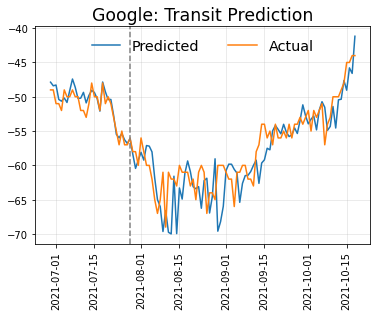

In [52]:

transit = pd.concat([y_mob_total_transit,
                data_mob0.transit.iloc[lag:].reset_index(drop = True),
                data_mob0.Date.iloc[lag:].reset_index(drop = True)], axis=1)

transit.columns = ['transit', "Actual", 'Date']

tick_spacing = 5
date_test = data_mob0['Date'][0+index+lag-1]

plt.plot(transit['Date'],transit['transit'], label = "Predicted")
plt.plot(transit['Date'],transit['Actual'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Google: Transit Prediction", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)


# Workplace

In [53]:
y_mob_tr = y_mob[0:index+1, :, 4]
y_mob_ts = y_mob[index+1:data_mob.shape[0], :, 4] # workplace

## Tuning

In [54]:
# CNN Tuning

def evaluate_cnn(trainX, trainy, filter, kernel_size, pool):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(Conv1D(filters = filter, kernel_size=kernel_size, activation='relu',input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size= pool))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# run an experiment
def run_experiment(filters, kernel_size, pool, trainX, trainy):
    # test each parameter
    all_scores = list()
    for filter in filters:
      for kernel in kernel_size:
        for pooling in pool:
          score = evaluate_cnn(trainX, trainy, filter, kernel_size, pool)
          print('filter = %d, kernel size = %d, pooling size = %d: %.3f' % (filter, kernel, pooling, score))
          all_scores.append(score)
    return all_scores
    


filter = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] 

kernel = [3, 5, 7]
pool = [2]
cnn_mob = list()

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool,X_mob_tr, y_mob_tr)
    cnn_mob.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_mob_tr, y_mob_tr)
    cnn_mob.append(score)

cnn_mob = pd.DataFrame(cnn_mob).T
cnn_mob.columns = ['k3p2', 'k5p2','k7p2', 'k3p3', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 44130144.000
filter = 4, kernel size = 3, pooling size = 2: 333069120.000
filter = 8, kernel size = 3, pooling size = 2: 111949312.000
filter = 16, kernel size = 3, pooling size = 2: 113627816.000
filter = 32, kernel size = 3, pooling size = 2: 49122688.000
filter = 64, kernel size = 3, pooling size = 2: 23689850.000
filter = 128, kernel size = 3, pooling size = 2: 23858564.000
filter = 256, kernel size = 3, pooling size = 2: 125813968.000
filter = 512, kernel size = 3, pooling size = 2: 171507552.000
filter = 1024, kernel size = 3, pooling size = 2: 22776612.000
filter = 2, kernel size = 5, pooling size = 2: 44111844.000
filter = 4, kernel size = 5, pooling size = 2: 159100768.000
filter = 8, kernel size = 5, pooling size = 2: 187873664.000
filter = 16, kernel size = 5, pooling size = 2: 129113144.000
filter = 32, kernel size = 5, pooling size = 2: 36550432.000
filter = 64, kernel size = 5, pooling size = 2: 48896264.000
filter = 128, ker

In [55]:
# LSTM
def evaluate_lstm(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(LSTM(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


units = [2, 4,8,16,32,64,128,256,512, 1024]

lstm_mob = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_mob_tr, y_mob_tr, i)
  lstm_mob.append(score)

In [56]:
# GRU
def evaluate_gru(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(GRU(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

gru_mob = list()

for i in units:
  score = list()
  score = evaluate_gru(X_mob_tr, y_mob_tr, i)
  gru_mob.append(score)

In [57]:
# RNN
def evaluate_rnn(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(SimpleRNN(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

rnn_mob = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_mob_tr, y_mob_tr, i)
  rnn_mob.append(score)

In [58]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes', '4 Nodes', '8 Nodes', '16 Nodes', '32 Nodes',
                                                   "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes', '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_mob[0],3), 
                                     round(gru_mob[0],3),
                                     round(rnn_mob[0],3), 
                                     round(cnn_mob.iloc[0,0],3),
                                     round(cnn_mob.iloc[0,1],3),
                                     round(cnn_mob.iloc[0,2],3),
                                     round(cnn_mob.iloc[0,3],3),
                                     round(cnn_mob.iloc[0,4],3),
                                     round(cnn_mob.iloc[0,5],3)],
                                     [round(lstm_mob[1],3), 
                                     round(gru_mob[1],3),
                                     round(rnn_mob[1],3), 
                                     round(cnn_mob.iloc[1,0],3),
                                     round(cnn_mob.iloc[1,1],3),
                                     round(cnn_mob.iloc[1,2],3),
                                     round(cnn_mob.iloc[1,3],3),
                                     round(cnn_mob.iloc[1,4],3),
                                     round(cnn_mob.iloc[1,5],3)],
                                     [round(lstm_mob[2],3), 
                                     round(gru_mob[2],3),
                                     round(rnn_mob[2],3), 
                                     round(cnn_mob.iloc[2,0],3),
                                     round(cnn_mob.iloc[2,1],3),
                                     round(cnn_mob.iloc[2,2],3),
                                     round(cnn_mob.iloc[2,3],3),
                                     round(cnn_mob.iloc[2,4],3),
                                     round(cnn_mob.iloc[2,5],3)],
                                     [round(lstm_mob[3],3), 
                                     round(gru_mob[3],3),
                                     round(rnn_mob[3],3), 
                                     round(cnn_mob.iloc[3,0],3),
                                     round(cnn_mob.iloc[3,1],3),
                                     round(cnn_mob.iloc[3,2],3),
                                     round(cnn_mob.iloc[3,3],3),
                                     round(cnn_mob.iloc[3,4],3),
                                     round(cnn_mob.iloc[3,5],3)],
                                     [round(lstm_mob[4],3), 
                                     round(gru_mob[4],3),
                                     round(rnn_mob[4],3), 
                                     round(cnn_mob.iloc[4,0],3),
                                     round(cnn_mob.iloc[4,1],3),
                                     round(cnn_mob.iloc[4,2],3),
                                     round(cnn_mob.iloc[4,3],3),
                                     round(cnn_mob.iloc[4,4],3),
                                     round(cnn_mob.iloc[4,5],3)],
                                     [round(lstm_mob[5],3), 
                                     round(gru_mob[5],3),
                                     round(rnn_mob[5],3), 
                                     round(cnn_mob.iloc[5,0],3),
                                     round(cnn_mob.iloc[5,1],3),
                                     round(cnn_mob.iloc[5,2],3),
                                     round(cnn_mob.iloc[5,3],3),
                                     round(cnn_mob.iloc[5,4],3),
                                     round(cnn_mob.iloc[5,5],3)],
                                     [round(lstm_mob[6],3), 
                                     round(gru_mob[6],3),
                                     round(rnn_mob[6],3), 
                                     round(cnn_mob.iloc[6,0],3),
                                     round(cnn_mob.iloc[6,1],3),
                                     round(cnn_mob.iloc[6,2],3),
                                     round(cnn_mob.iloc[6,3],3),
                                     round(cnn_mob.iloc[6,4],3),
                                     round(cnn_mob.iloc[6,5],3)],
                                     [round(lstm_mob[7],3), 
                                     round(gru_mob[7],3),
                                     round(rnn_mob[7],3), 
                                     round(cnn_mob.iloc[7,0],3),
                                     round(cnn_mob.iloc[7,1],3),
                                     round(cnn_mob.iloc[7,2],3),
                                     round(cnn_mob.iloc[7,3],3),
                                     round(cnn_mob.iloc[7,4],3),
                                     round(cnn_mob.iloc[7,5],3)],
                                     [round(lstm_mob[8],3), 
                                     round(gru_mob[8],3),
                                     round(rnn_mob[8],3), 
                                     round(cnn_mob.iloc[8,0],3),
                                     round(cnn_mob.iloc[8,1],3),
                                     round(cnn_mob.iloc[8,2],3),
                                     round(cnn_mob.iloc[8,3],3),
                                     round(cnn_mob.iloc[8,4],3),
                                     round(cnn_mob.iloc[8,5],3)],
                                     [round(lstm_mob[9],3), 
                                     round(gru_mob[9],3),
                                     round(rnn_mob[9],3), 
                                     round(cnn_mob.iloc[9,0],3),
                                     round(cnn_mob.iloc[9,1],3),
                                     round(cnn_mob.iloc[9,2],3),
                                     round(cnn_mob.iloc[9,3],3),
                                     round(cnn_mob.iloc[9,4],3),
                                     round(cnn_mob.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right', 'right', 'right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Google Mobility",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

## Prediction

In [59]:
seed(1)
tensorflow.random.set_seed(1)

model_mob = Sequential()
model_mob.add(GRU(256, activation='relu', input_shape=(X_mob_tr.shape[1], X_mob_tr.shape[2])))
# model_mob.add(Dense(2, activation = "relu"))
model_mob.add(Dense(1, activation = "linear"))
model_mob.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_mob.fit(X_mob_tr, y_mob_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

scores_mob1 = model_mob.evaluate(X_mob_tr, y_mob_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_mob1[1])

scores_mob = model_mob.evaluate(X_mob_ts, y_mob_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_mob[1])


# make a prediction
# training set
y_mob_tr = pd.DataFrame(model_mob.predict(X_mob_tr))

# test set
y_mob_ts = pd.DataFrame(model_mob.predict(X_mob_ts))

# combine training and test predictions
y_mob_total_workplace = pd.concat([y_mob_tr, y_mob_ts], ignore_index=True)



MAPE: training =  11372724.0
MAPE: test =  23.754268646240234


## Plot

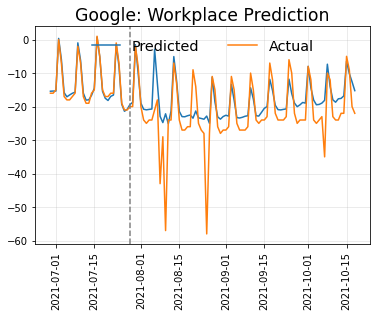

In [60]:

workplace = pd.concat([y_mob_total_workplace,
                data_mob0.workplace.iloc[lag:].reset_index(drop = True),
                data_mob0.Date.iloc[lag:].reset_index(drop = True)], axis=1)

workplace.columns = ['workplace', "Actual", 'Date']

tick_spacing = 5
date_test = data_mob0['Date'][0+index+lag-1]

plt.plot(workplace['Date'],workplace['workplace'], label = "Predicted")
plt.plot(workplace['Date'],workplace['Actual'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Google: Workplace Prediction", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)


# Resident

In [62]:
y_mob_tr = y_mob[0:index+1, :, 5]
y_mob_ts = y_mob[index+1:data_mob.shape[0], :, 5] # resident

## Tuning

In [63]:
# CNN Tuning

def evaluate_cnn(trainX, trainy, filter, kernel_size, pool):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(Conv1D(filters = filter, kernel_size=kernel_size, activation='relu',input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size= pool))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# run an experiment
def run_experiment(filters, kernel_size, pool, trainX, trainy):
    # test each parameter
    all_scores = list()
    for filter in filters:
      for kernel in kernel_size:
        for pooling in pool:
          score = evaluate_cnn(trainX, trainy, filter, kernel_size, pool)
          print('filter = %d, kernel size = %d, pooling size = %d: %.3f' % (filter, kernel, pooling, score))
          all_scores.append(score)
    return all_scores
    


filter = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] 

kernel = [3, 5, 7]
pool = [2]
cnn_mob = list()

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool,X_mob_tr, y_mob_tr)
    cnn_mob.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_mob_tr, y_mob_tr)
    cnn_mob.append(score)

cnn_mob = pd.DataFrame(cnn_mob).T
cnn_mob.columns = ['k3p2', 'k5p2','k7p2', 'k3p3', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 69.546
filter = 4, kernel size = 3, pooling size = 2: 27.546
filter = 8, kernel size = 3, pooling size = 2: 15.253
filter = 16, kernel size = 3, pooling size = 2: 33.658
filter = 32, kernel size = 3, pooling size = 2: 16.983
filter = 64, kernel size = 3, pooling size = 2: 7.058
filter = 128, kernel size = 3, pooling size = 2: 8.002
filter = 256, kernel size = 3, pooling size = 2: 8.741
filter = 512, kernel size = 3, pooling size = 2: 32.226
filter = 1024, kernel size = 3, pooling size = 2: 27.366
filter = 2, kernel size = 5, pooling size = 2: 36.504
filter = 4, kernel size = 5, pooling size = 2: 26.645
filter = 8, kernel size = 5, pooling size = 2: 8.479
filter = 16, kernel size = 5, pooling size = 2: 25.227
filter = 32, kernel size = 5, pooling size = 2: 16.267
filter = 64, kernel size = 5, pooling size = 2: 9.176
filter = 128, kernel size = 5, pooling size = 2: 8.047
filter = 256, kernel size = 5, pooling size = 2: 20.414
filter = 512, k

In [64]:
# LSTM
def evaluate_lstm(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(LSTM(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


units = [2, 4,8,16,32,64,128,256,512, 1024]

lstm_mob = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_mob_tr, y_mob_tr, i)
  lstm_mob.append(score)

In [65]:
# GRU
def evaluate_gru(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(GRU(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

gru_mob = list()

for i in units:
  score = list()
  score = evaluate_gru(X_mob_tr, y_mob_tr, i)
  gru_mob.append(score)

In [66]:
# RNN
def evaluate_rnn(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(SimpleRNN(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

rnn_mob = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_mob_tr, y_mob_tr, i)
  rnn_mob.append(score)

In [67]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes', '4 Nodes', '8 Nodes', '16 Nodes', '32 Nodes',
                                                   "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes', '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_mob[0],3), 
                                     round(gru_mob[0],3),
                                     round(rnn_mob[0],3), 
                                     round(cnn_mob.iloc[0,0],3),
                                     round(cnn_mob.iloc[0,1],3),
                                     round(cnn_mob.iloc[0,2],3),
                                     round(cnn_mob.iloc[0,3],3),
                                     round(cnn_mob.iloc[0,4],3),
                                     round(cnn_mob.iloc[0,5],3)],
                                     [round(lstm_mob[1],3), 
                                     round(gru_mob[1],3),
                                     round(rnn_mob[1],3), 
                                     round(cnn_mob.iloc[1,0],3),
                                     round(cnn_mob.iloc[1,1],3),
                                     round(cnn_mob.iloc[1,2],3),
                                     round(cnn_mob.iloc[1,3],3),
                                     round(cnn_mob.iloc[1,4],3),
                                     round(cnn_mob.iloc[1,5],3)],
                                     [round(lstm_mob[2],3), 
                                     round(gru_mob[2],3),
                                     round(rnn_mob[2],3), 
                                     round(cnn_mob.iloc[2,0],3),
                                     round(cnn_mob.iloc[2,1],3),
                                     round(cnn_mob.iloc[2,2],3),
                                     round(cnn_mob.iloc[2,3],3),
                                     round(cnn_mob.iloc[2,4],3),
                                     round(cnn_mob.iloc[2,5],3)],
                                     [round(lstm_mob[3],3), 
                                     round(gru_mob[3],3),
                                     round(rnn_mob[3],3), 
                                     round(cnn_mob.iloc[3,0],3),
                                     round(cnn_mob.iloc[3,1],3),
                                     round(cnn_mob.iloc[3,2],3),
                                     round(cnn_mob.iloc[3,3],3),
                                     round(cnn_mob.iloc[3,4],3),
                                     round(cnn_mob.iloc[3,5],3)],
                                     [round(lstm_mob[4],3), 
                                     round(gru_mob[4],3),
                                     round(rnn_mob[4],3), 
                                     round(cnn_mob.iloc[4,0],3),
                                     round(cnn_mob.iloc[4,1],3),
                                     round(cnn_mob.iloc[4,2],3),
                                     round(cnn_mob.iloc[4,3],3),
                                     round(cnn_mob.iloc[4,4],3),
                                     round(cnn_mob.iloc[4,5],3)],
                                     [round(lstm_mob[5],3), 
                                     round(gru_mob[5],3),
                                     round(rnn_mob[5],3), 
                                     round(cnn_mob.iloc[5,0],3),
                                     round(cnn_mob.iloc[5,1],3),
                                     round(cnn_mob.iloc[5,2],3),
                                     round(cnn_mob.iloc[5,3],3),
                                     round(cnn_mob.iloc[5,4],3),
                                     round(cnn_mob.iloc[5,5],3)],
                                     [round(lstm_mob[6],3), 
                                     round(gru_mob[6],3),
                                     round(rnn_mob[6],3), 
                                     round(cnn_mob.iloc[6,0],3),
                                     round(cnn_mob.iloc[6,1],3),
                                     round(cnn_mob.iloc[6,2],3),
                                     round(cnn_mob.iloc[6,3],3),
                                     round(cnn_mob.iloc[6,4],3),
                                     round(cnn_mob.iloc[6,5],3)],
                                     [round(lstm_mob[7],3), 
                                     round(gru_mob[7],3),
                                     round(rnn_mob[7],3), 
                                     round(cnn_mob.iloc[7,0],3),
                                     round(cnn_mob.iloc[7,1],3),
                                     round(cnn_mob.iloc[7,2],3),
                                     round(cnn_mob.iloc[7,3],3),
                                     round(cnn_mob.iloc[7,4],3),
                                     round(cnn_mob.iloc[7,5],3)],
                                     [round(lstm_mob[8],3), 
                                     round(gru_mob[8],3),
                                     round(rnn_mob[8],3), 
                                     round(cnn_mob.iloc[8,0],3),
                                     round(cnn_mob.iloc[8,1],3),
                                     round(cnn_mob.iloc[8,2],3),
                                     round(cnn_mob.iloc[8,3],3),
                                     round(cnn_mob.iloc[8,4],3),
                                     round(cnn_mob.iloc[8,5],3)],
                                     [round(lstm_mob[9],3), 
                                     round(gru_mob[9],3),
                                     round(rnn_mob[9],3), 
                                     round(cnn_mob.iloc[9,0],3),
                                     round(cnn_mob.iloc[9,1],3),
                                     round(cnn_mob.iloc[9,2],3),
                                     round(cnn_mob.iloc[9,3],3),
                                     round(cnn_mob.iloc[9,4],3),
                                     round(cnn_mob.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right', 'right', 'right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Google Mobility",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

## Prediction

In [78]:
seed(1)
tensorflow.random.set_seed(1)

model_mob = Sequential()
model_mob.add(Conv1D(128, kernel_size = 5, activation='relu', input_shape=(X_mob_tr.shape[1], X_mob_tr.shape[2])))
model_mob.add(MaxPooling1D(3))
model_mob.add(Flatten())
model_mob.add(Dense(2, activation = "relu"))
model_mob.add(Dense(1, activation = "linear"))
model_mob.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_mob.fit(X_mob_tr, y_mob_tr, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

scores_mob1 = model_mob.evaluate(X_mob_tr, y_mob_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_mob1[1])

scores_mob = model_mob.evaluate(X_mob_ts, y_mob_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_mob[1])


# make a prediction
# training set
y_mob_tr = pd.DataFrame(model_mob.predict(X_mob_tr))

# test set
y_mob_ts = pd.DataFrame(model_mob.predict(X_mob_ts))

# combine training and test predictions
y_mob_total_resident = pd.concat([y_mob_tr, y_mob_ts], ignore_index=True)



MAPE: training =  3.906163215637207
MAPE: test =  2.8228771686553955


## Plot

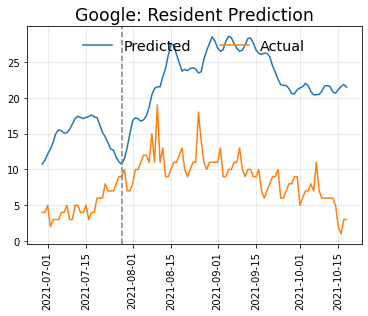

In [81]:

resident = pd.concat([y_mob_total_resident,
                data_mob0.resident.iloc[lag:].reset_index(drop = True),
                data_mob0.Date.iloc[lag:].reset_index(drop = True)], axis=1)

resident.columns = ['resident', "Actual", 'Date']


plt.plot(resident['Date'],resident['resident'], label = "Predicted")
plt.plot(resident['Date'],resident['Actual'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Google: Resident Prediction", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)
